# Simulation of a propogating LIDAR pulse

This file will deal with simulating a LIDAR pulse as it propogates through the atmosphere.
This will occur each time step, considering two populations of photons: those scattering upwards, and those scattering downwards.


In [1]:
# initial imports
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import poisson
import copy

# the atmospheric profiles to be generated
import profiles

from GreyGas import GreyGas

### Parameter setup

In this section of code, I'll set up the parameters that will gvern the simulation. This will include the LIDAR pulse energy, pulse duration, the atmospheric profile, any required scattering cross sections, etc.

In [2]:
# setting up the LIDAR emission parameters
PULSE_energy = 0.150 # (J)
PULSE_duration = 10e-6 # (s)
PULSE_wavelength = 770e-9 # (m)

h = 6.63e-34 # (m^2 kg/s) Planck constant
c = 3e8 # (m/s) speed of light

PULSE_photonCount = PULSE_energy * PULSE_wavelength / h / c
print(PULSE_photonCount)

5.806938159879337e+17


In [3]:
# setting up the simuulation parameters
# this will include the time-step, maximum altitude to measure to, etc

dt = 1e-6 # (s) the time step for the simulation. #### FOR NOW, will use this as the temporal resolution for the detector too. Implement integration time at the detector?
hmax = 70e3 # (m) maximum height we want to consider.
dr = c*dt / 2 # (m) the spatial resolution to be achieved by the time-step (NOT the spatial resolution of the instrument)

tmax = 2*2*hmax/c + PULSE_duration # (s) the maximum time we will have to run the simulation until

z = np.arange(dr,hmax,dr)
time = np.arange(0,tmax,dt)

In [5]:
# setting up the atmospheric parameters. This will include the T,p,rho profiles, as well as the absorber profiles
#T,p,rho = profiles.US_standard_atmosphere_1976(z)
T,p,rho = profiles.Isothermal_hydrostatic(z)

m_bar = 28.964 * 1.66e-27 # (kg) the average mass of the air particles in our grey gas   #28.964 g/mol
n_z = rho / m_bar

cs_sca = 1e-32 # (m^2) the scattering cross-section for the grey gas
cs_abs = 0.4e-32 # (m^2) the absorption cross-section for the grey gas

# creating the grey gas profile
GG = GreyGas(z,n_z,cs_sca,cs_abs)

In [6]:
# this section will deal with the creation of the aerosol profile. For this, I will place two narrow Gaussian distributed bands of aerosol.
# One will be at 5km, the other will be at 35km.
hpeak = [5e3,35e3] # (m) the altitudes of peak aerosol concentration
sd = [200,1e3] # (m) the standard deviation of the distributions

zAero = 10e3
nair_zAero = n_z[np.logical_and( z > zAero-dr , z < zAero + dr )][0]
npeak = [nair_zAero,nair_zAero / 10] # (/m^3) the peak number density of the aerosols


def Gaussian(x,xbar,sd):
    return np.exp( -np.power( x-xbar ,2) / (2*np.power(sd,2)) )


n_aerosol = np.zeros(z.shape)
# I will perform the distribution for points within 5 sd of the peaks
mask_lower = np.logical_and( z > hpeak[0] - 5*sd[0] , z < hpeak[0] + 5*sd[0] )
mask_upper = np.logical_and( z > hpeak[1] - 5*sd[1] , z < hpeak[1] + 5*sd[1] )

n_aerosol[mask_lower] = npeak[0]*Gaussian(z[mask_lower],hpeak[0],sd[0])
n_aerosol[mask_upper] = npeak[1]*Gaussian(z[mask_upper],hpeak[1],sd[1])

acs_sca =  10e-32# (m^2) scattering cross-section of the aerosol
acs_abs =  0.5e-32# (m^2) absorption cross-section of the aerosol

Aerosol = GreyGas(z,n_aerosol,acs_sca,acs_abs)

In [7]:
# setting up the detector parameters
DETECTOR_area = 0.5 # (m^2)
SA = DETECTOR_area / np.power(z,2) # (m^2/sr) the solid angle subtended by the detector at each height.

DETECTOR_efficiency = 0.33

DETECTOR_backgroundMean = 10 # mean background detector rate for a poisson distributed noise

DETECTOR_GainSequence = [1e-3,1] # values for the detector gain that can be switched
DETECTOR_GainTimings = [-1,50e-6] # the timings for when the detector gain switches. The initial timing should be <=0 to set the initial gain parameter to anything other than 1

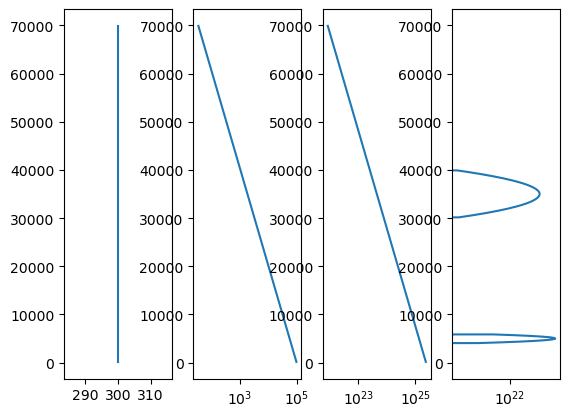

In [8]:
# plotting the profiles we've generated to make sure that they seem reasonable:
nplots = 4

fig = plt.figure()

ax = fig.add_subplot(1,nplots,1)
ax.plot(T,z)

ax = fig.add_subplot(1,nplots,2)
ax.plot(p,z)
ax.set_xscale('log')

ax = fig.add_subplot(1,nplots,3)
ax.plot(GG.n_z,z)
ax.set_xscale('log')

ax = fig.add_subplot(1,nplots,4)
ax.plot(Aerosol.n_z,z)
ax.set_xscale('log')

## The simulation:

Once all of the setup has been done, we will simulate the signal propogating through the atmosphere.

The simulation will be broken into the time steps given by dt. For each given dt, we will:

+ If t < PULSE_duration, we will pump photons into the upwards stream
+ For each altitude, we will simulate scattering of the upwards photons into a stream that will return to the detector (the downwards stream)
+ For each altitude, we will also simulate attenuation of the beam into other solid angles, either by scattering or absorption (depletion from the upwards stream)
+ For photons in the downward stream at z[0], we will simulate their passage into the detector. This will be affected by gain, efficiency and shot noise.

At the end of the time-step, we will propogate the remaining photons into the next bin vertically (up or down) that they should travel into. t will then be incremented.

gain sequence popping [-1, 5e-05] [0.001, 1]


/tmp/ipykernel_45654/3755152608.py:103: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_animdown.set_xscale('log')


Saved frame 0 as figures/frame00000.png
Saved frame 1 as figures/frame00001.png
Saved frame 2 as figures/frame00002.png
Saved frame 3 as figures/frame00003.png
Saved frame 4 as figures/frame00004.png
Saved frame 5 as figures/frame00005.png
Saved frame 6 as figures/frame00006.png
Saved frame 7 as figures/frame00007.png
Saved frame 8 as figures/frame00008.png
Saved frame 9 as figures/frame00009.png
Saved frame 10 as figures/frame00010.png
Saved frame 11 as figures/frame00011.png
Saved frame 12 as figures/frame00012.png
Saved frame 13 as figures/frame00013.png
Saved frame 14 as figures/frame00014.png
Saved frame 15 as figures/frame00015.png
Saved frame 16 as figures/frame00016.png
Saved frame 17 as figures/frame00017.png
Saved frame 18 as figures/frame00018.png
Saved frame 19 as figures/frame00019.png
Saved frame 20 as figures/frame00020.png
Saved frame 21 as figures/frame00021.png
Saved frame 22 as figures/frame00022.png
Saved frame 23 as figures/frame00023.png
Saved frame 24 as figures/

/tmp/ipykernel_45654/3755152608.py:101: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_animup.set_xscale('log')


Saved frame 475 as figures/frame00475.png
Saved frame 476 as figures/frame00476.png
Saved frame 477 as figures/frame00477.png
Saved frame 478 as figures/frame00478.png
Saved frame 479 as figures/frame00479.png
Saved frame 480 as figures/frame00480.png
Saved frame 481 as figures/frame00481.png
Saved frame 482 as figures/frame00482.png
Saved frame 483 as figures/frame00483.png
Saved frame 484 as figures/frame00484.png
Saved frame 485 as figures/frame00485.png
Saved frame 486 as figures/frame00486.png
Saved frame 487 as figures/frame00487.png
Saved frame 488 as figures/frame00488.png
Saved frame 489 as figures/frame00489.png
Saved frame 490 as figures/frame00490.png
Saved frame 491 as figures/frame00491.png
Saved frame 492 as figures/frame00492.png
Saved frame 493 as figures/frame00493.png
Saved frame 494 as figures/frame00494.png
Saved frame 495 as figures/frame00495.png
Saved frame 496 as figures/frame00496.png
Saved frame 497 as figures/frame00497.png
Saved frame 498 as figures/frame00

/tmp/ipykernel_45654/3755152608.py:115: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_up.set_xscale('log')
/tmp/ipykernel_45654/3755152608.py:119: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_down.set_xscale('log')


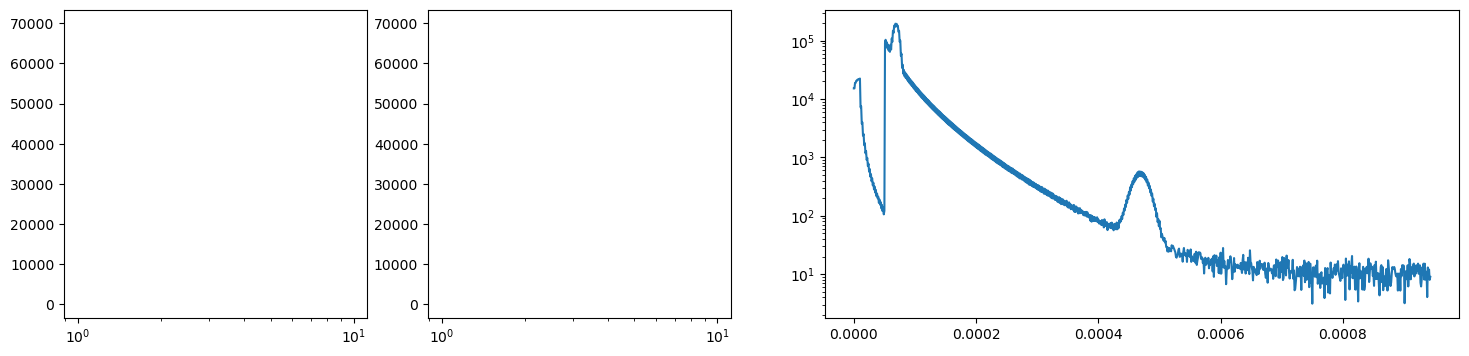

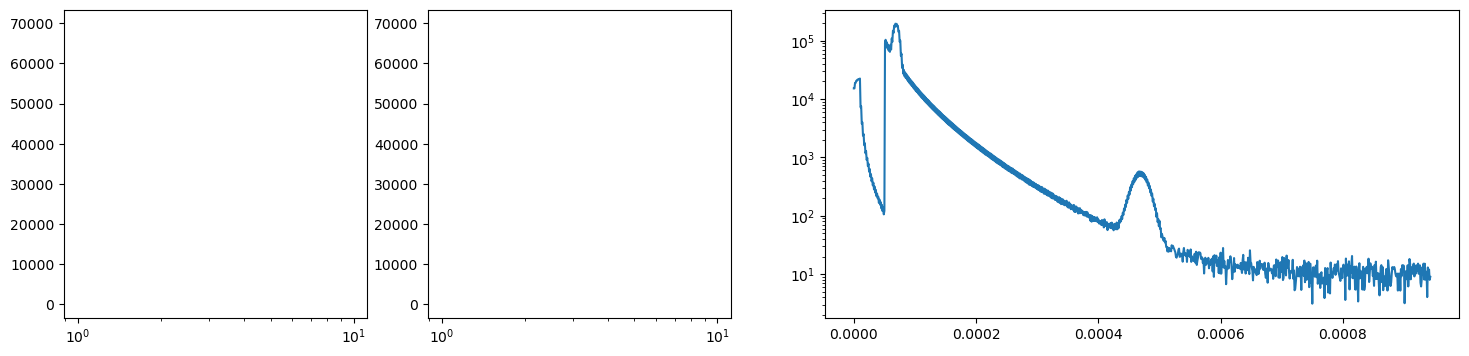

In [9]:
plotVerbose = False # flag for plotting a sequence of figures once the simulation is complete.
animateSimulation = False # flag for saving frames of the simulation to turn into an animation.

# ALL the setup pertaining to plotVerbose
figUpdates = 0
if plotVerbose:
    figUpdates = 10
    updateItter = list(np.linspace(0,tmax,num=2*figUpdates+1,endpoint=False))[1:figUpdates+1]
    updateItterI = list(range(figUpdates))
    
    fig = plt.figure(figsize=(18,4*(figUpdates+1)))

    plt.ion()
    fig.show()
    fig.canvas.draw()
else:
    fig = plt.figure(figsize=(18,4))

# ALL the setup pertaining to animateSimulation
if animateSimulation:
    frameSkip = 1#10 # [int > 0] the amount of frames to be skipped when saving frames.
    totalFrames = np.floor(time.shape[0]/frameSkip)+1
    dp = len(str(totalFrames)) - 1
    saveFolder = 'figures/'
    filenameFormat = 'frame{}.png'
    frame = 0
    figAnim = plt.figure(figsize=(18,4))
    ax_animup = figAnim.add_subplot(1,4,1)
    ax_animdown = figAnim.add_subplot(1,4,2)
    ax_animsignal = figAnim.add_subplot(1,2,2)


N_up = np.zeros(z.shape) # upwards propogating photons
N_down = np.zeros(z.shape) # downwards propogating photons

Nsca_up = np.zeros(z.shape) # for each time step, the number of photons that scatter from the given direction
Nsca_down = np.zeros(z.shape)

S = np.zeros(time.shape) # signal

dists = [GG,Aerosol]
sumBeta = np.sum([d.beta for d in dists],axis=0)
sumBetaAbs = np.sum([ d.beta * (d.cs_abs / d.cs_sca) for d in dists ],axis=0)

currentGain = 1
GSeq = copy.deepcopy(DETECTOR_GainSequence)
GTime = copy.deepcopy(DETECTOR_GainTimings)
# start the simulation:
for i,t in enumerate(time): # for each time step...
    # start by pumping the laser
    if t <= PULSE_duration:
        N_up[0] = (PULSE_photonCount * dt / PULSE_duration)

    # next, evaluate the loss of photons from the upward beam due to scattering
    Nsca_up = N_up * dr * sumBeta
    Nsca_down = N_down * dr * sumBeta # for the downwards beam too

    # evaluate the loss of photons due to absorption too
    N_up = N_up * (1 - dr*sumBetaAbs) - Nsca_up
    N_down = N_down * (1 - dr*sumBetaAbs) - Nsca_down + Nsca_up * SA

    
    # now we've evaluated the photon population changes, need to model the detector
    if GTime and t > GTime[0]: # updates the gain if the sequence requires it.
        print('gain sequence popping',GTime,GSeq)
        GTime.pop(0)
        currentGain = GSeq.pop(0)
    S[i] = N_down[0] * DETECTOR_efficiency * currentGain
    S[i] = S[i] + poisson.rvs(DETECTOR_backgroundMean) # add some noise to the signal

    # now, shift the photon populations
    N_up[1:] = N_up[:-1]
    N_down[:-1] = N_down[1:]
    N_up[0] = 0
    N_down[-1] = 0

    # now, if plotting verbose is true, update the plots
    if plotVerbose and updateItter and t > updateItter[0]:
        updateItter.pop(0)
        row = updateItterI.pop(0)
        ax_up = fig.add_subplot(figUpdates+1,4,row*4+1) # for showing the upwards propogating signal
        ax_up.plot(N_up,z)
        ax_up.set_xscale('log')

        ax_down = fig.add_subplot(figUpdates+1,4,row*4+2) # for showing the downwards propogating signal
        ax_down.plot(N_down,z)
        ax_down.set_xscale('log')

        ax_detector = fig.add_subplot(figUpdates+1,2,row*2+2) # for showing the signal at the detector (double width)
        ax_detector.plot(time,S)
        ax_detector.set_yscale('log')
        
        fig.canvas.draw()

    if animateSimulation and not i%frameSkip:
        frameStr = str(frame).zfill(dp) # get the frame number with sufficient leading zeros.
        ax_animup.clear()
        ax_animdown.clear()
        ax_animsignal.clear()
        ax_animup.plot(N_up,z)
        ax_animup.set_xscale('log')
        ax_animdown.plot(N_down,z)
        ax_animdown.set_xscale('log')
        ax_animsignal.plot(time,S)
        ax_animsignal.set_yscale('log')
        figAnim.savefig(saveFolder + filenameFormat.format(frameStr))
        print('Saved frame {} as {}'.format(frame,saveFolder + filenameFormat.format(frameStr)))
        frame += 1



# once everything is done, draw out the final stuff on ax_detector
ax_up = fig.add_subplot(figUpdates+1,4,figUpdates*4+1) # for showing the upwards propogating signal
ax_up.plot(N_up,z)
ax_up.set_xscale('log')

ax_down = fig.add_subplot(figUpdates+1,4,figUpdates*4+2) # for showing the downwards propogating signal
ax_down.plot(N_down,z)
ax_down.set_xscale('log')

ax_detector = fig.add_subplot(figUpdates+1,2,figUpdates*2+2) # for showing the signal at the detector (double width)
ax_detector.plot(time,S)
ax_detector.set_yscale('log')

plt.show()